In [1]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogLocator, FuncFormatter, FormatStrFormatter
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from pathlib import Path
from glob import glob
import solar_plotting

from spectrum import pmtm
import pywt
from scipy.signal import welch
from scipy.signal import convolve

import geopandas as gpd
import pyogrio
import rasterio
from rasterio.mask import mask
from pyproj import CRS
from shapely.geometry import Point

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging
logging.getLogger("flox").setLevel(logging.WARNING)

In [4]:
plt.rcParams.update({
    'axes.titlesize': 22,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

In [5]:
fig_dir = '/home/548/cd3022/aus-historical-solar-droughts/figs/REZ/CSG/'

# Prepare Data

In [6]:
# regions = ['Q', 'N', 'V', 'S', 'T']  # States
regions = ['Q2', 'Q8', 'N3', 'N5', 'V5', 'V6', 'T1', 'T3', 'S7', 'S8']
ncols = (len(regions) + 1) // 2 # plotting
base_path = Path('/g/data/er8/users/cd3022/solar_drought/REZ/V1.0/clear_sky_generation/')

region_darrays = {}

for region in regions:
    file_path = base_path / region
    files = list(file_path.rglob("*.nc"))
    ds_region = xr.open_mfdataset(files, combine='by_coords')
    
    # Assume there's only one data variable in the dataset
    data_var = list(ds_region.data_vars)[0]
    region_darrays[region] = ds_region[data_var]

# Combine into one dataset, with each region as a variable
ds = xr.Dataset(region_darrays)
ds = ds.load()
# Assign Brisbane time
time_utc = pd.to_datetime(ds.time.values)
time_aest = time_utc.tz_localize("UTC").tz_convert("Australia/Brisbane")
time_aest_naive = time_aest.tz_convert("Australia/Brisbane").tz_localize(None)
ds = ds.assign_coords(time=("time", time_aest_naive))

### Remove the 3 bad days

In [7]:
bad_days = [
    np.datetime64('2019-08-12'),
    np.datetime64('2019-10-01'),
    np.datetime64('2020-09-06'),
    
]
ds_dates = ds['time'].dt.floor('D')
good_time_mask = ~ds_dates.isin(bad_days)
ds = ds.sel(time=ds['time'][good_time_mask])

### Assign "time of year" coordinate for bias correction

In [8]:
ds = ds.assign_coords(
        time_of_year=ds['time'].dt.strftime("%m-%d")
    )

### Remove dusk and dawn data

In [9]:
# REMOVE BAD DUSK AND DAWN DATA
for reg in regions:
    ds[reg] = solar_plotting.clip_dusk_dawn(ds[reg], n=6)

# Bias Analysis

In [10]:
# Only look at the middle hours when finding biases
mask = (ds['time'].dt.hour > 10) & (ds['time'].dt.hour < 15)

In [11]:
def get_bias(da):
    # prevent actual cloudy data from bringing down mean
    da = da.clip(min=0.95)
    da_biases = da.rolling(time_of_year=30, center=True, min_periods=1).max()
    da_biases_smooth = da_biases.rolling(time_of_year=100, center=True, min_periods=1).mean()
    return da_biases_smooth

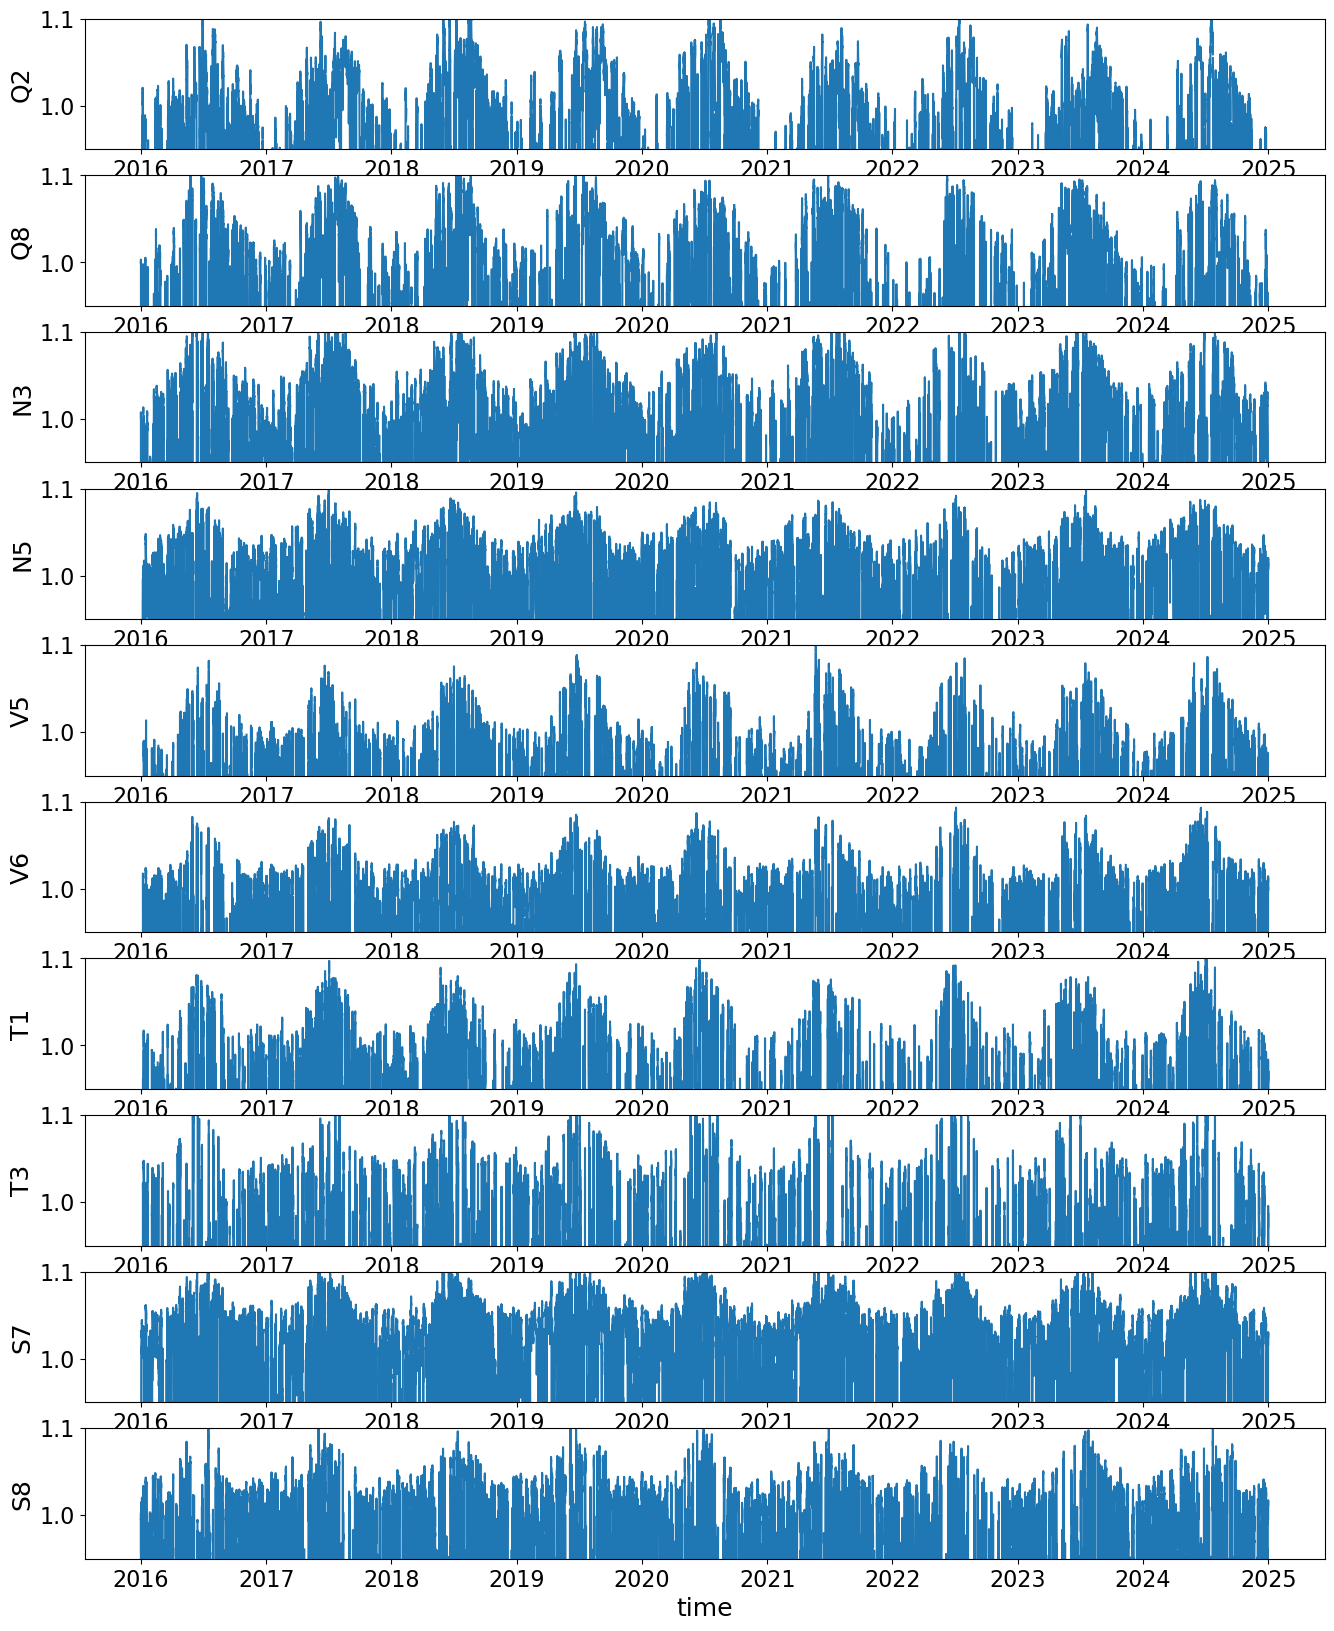

In [12]:
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(16, 20))
for i, reg in enumerate(regions):
    ds[reg][mask].plot(ax=ax[i])
    ax[i].set_ylim(0.95, 1.1)

<Axes: >

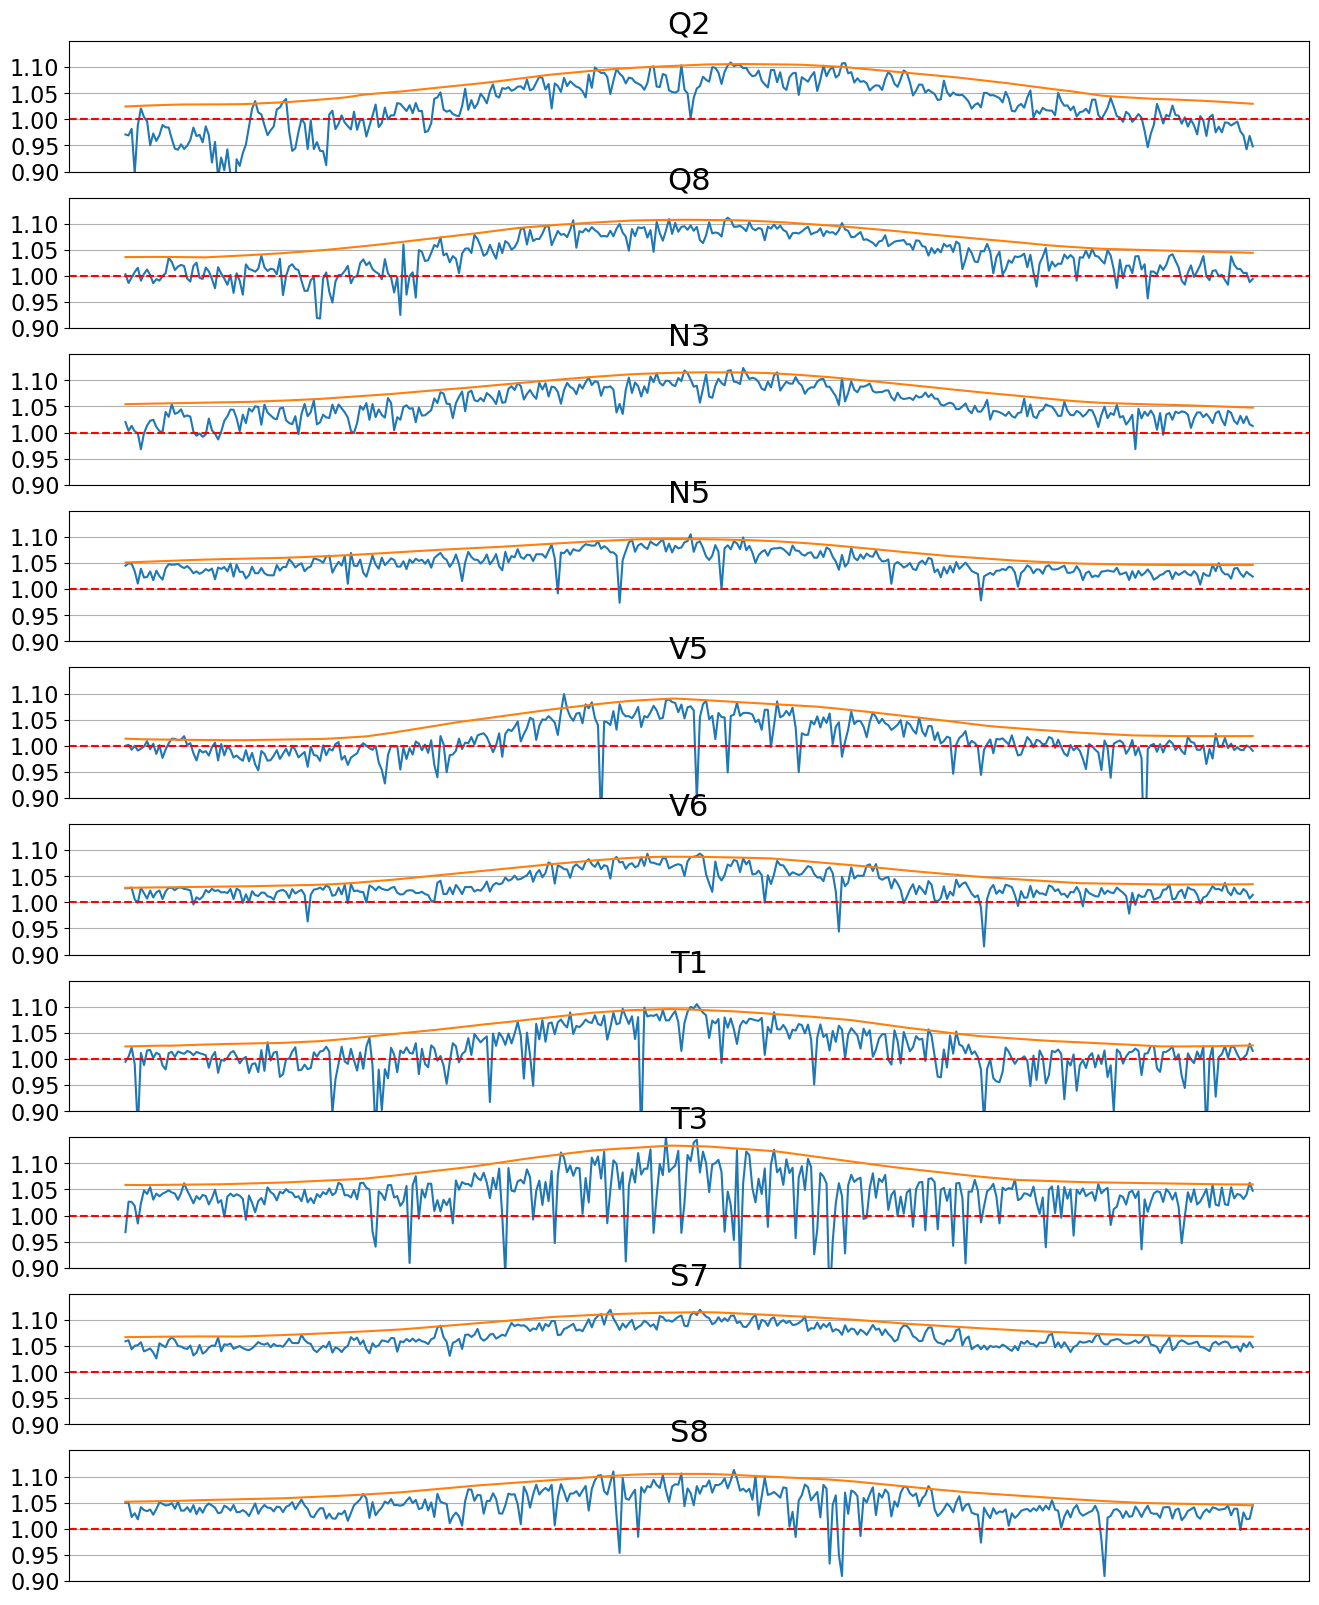

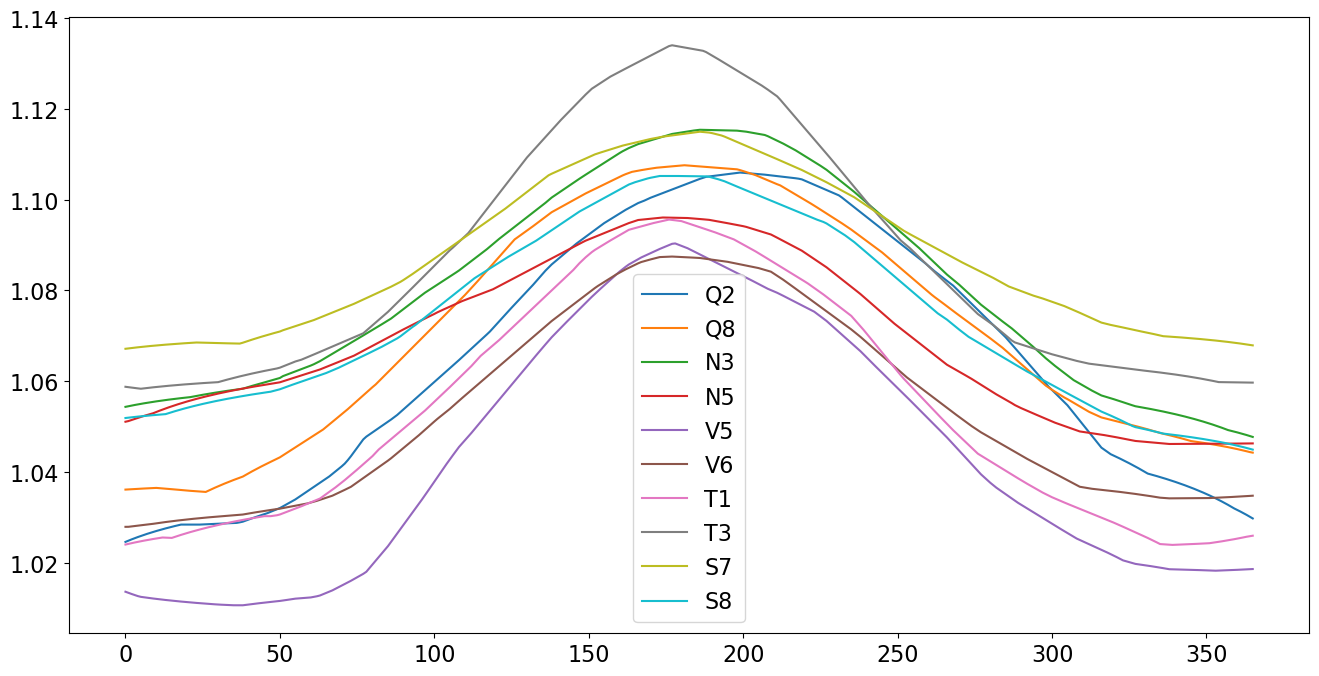

In [13]:
bias = {}
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(16, 20))
for i, reg in enumerate(regions):
    ax[i].plot(ds[reg][mask].groupby('time_of_year').max().values)
    reg_bias = get_bias(ds[reg][mask].groupby('time_of_year').max())
    ax[i].plot(reg_bias.values)
    bias[reg] = reg_bias.values
    ax[i].set_ylim(0.9, 1.15)
    ax[i].set_yticks([1])
    ax[i].axhline(1, color='r', linestyle='--')
    ax[i].set_yticks(np.linspace(0.9, 1.1, 5))
    ax[i].set_xticks([])
    ax[i].set_title(reg)
    ax[i].grid(True)
bias_df = pd.DataFrame(
    bias,
    # index=ds_aus.resample(time='1D').max().time
)
bias_df.plot(figsize=(16,8))

# Bias Correction

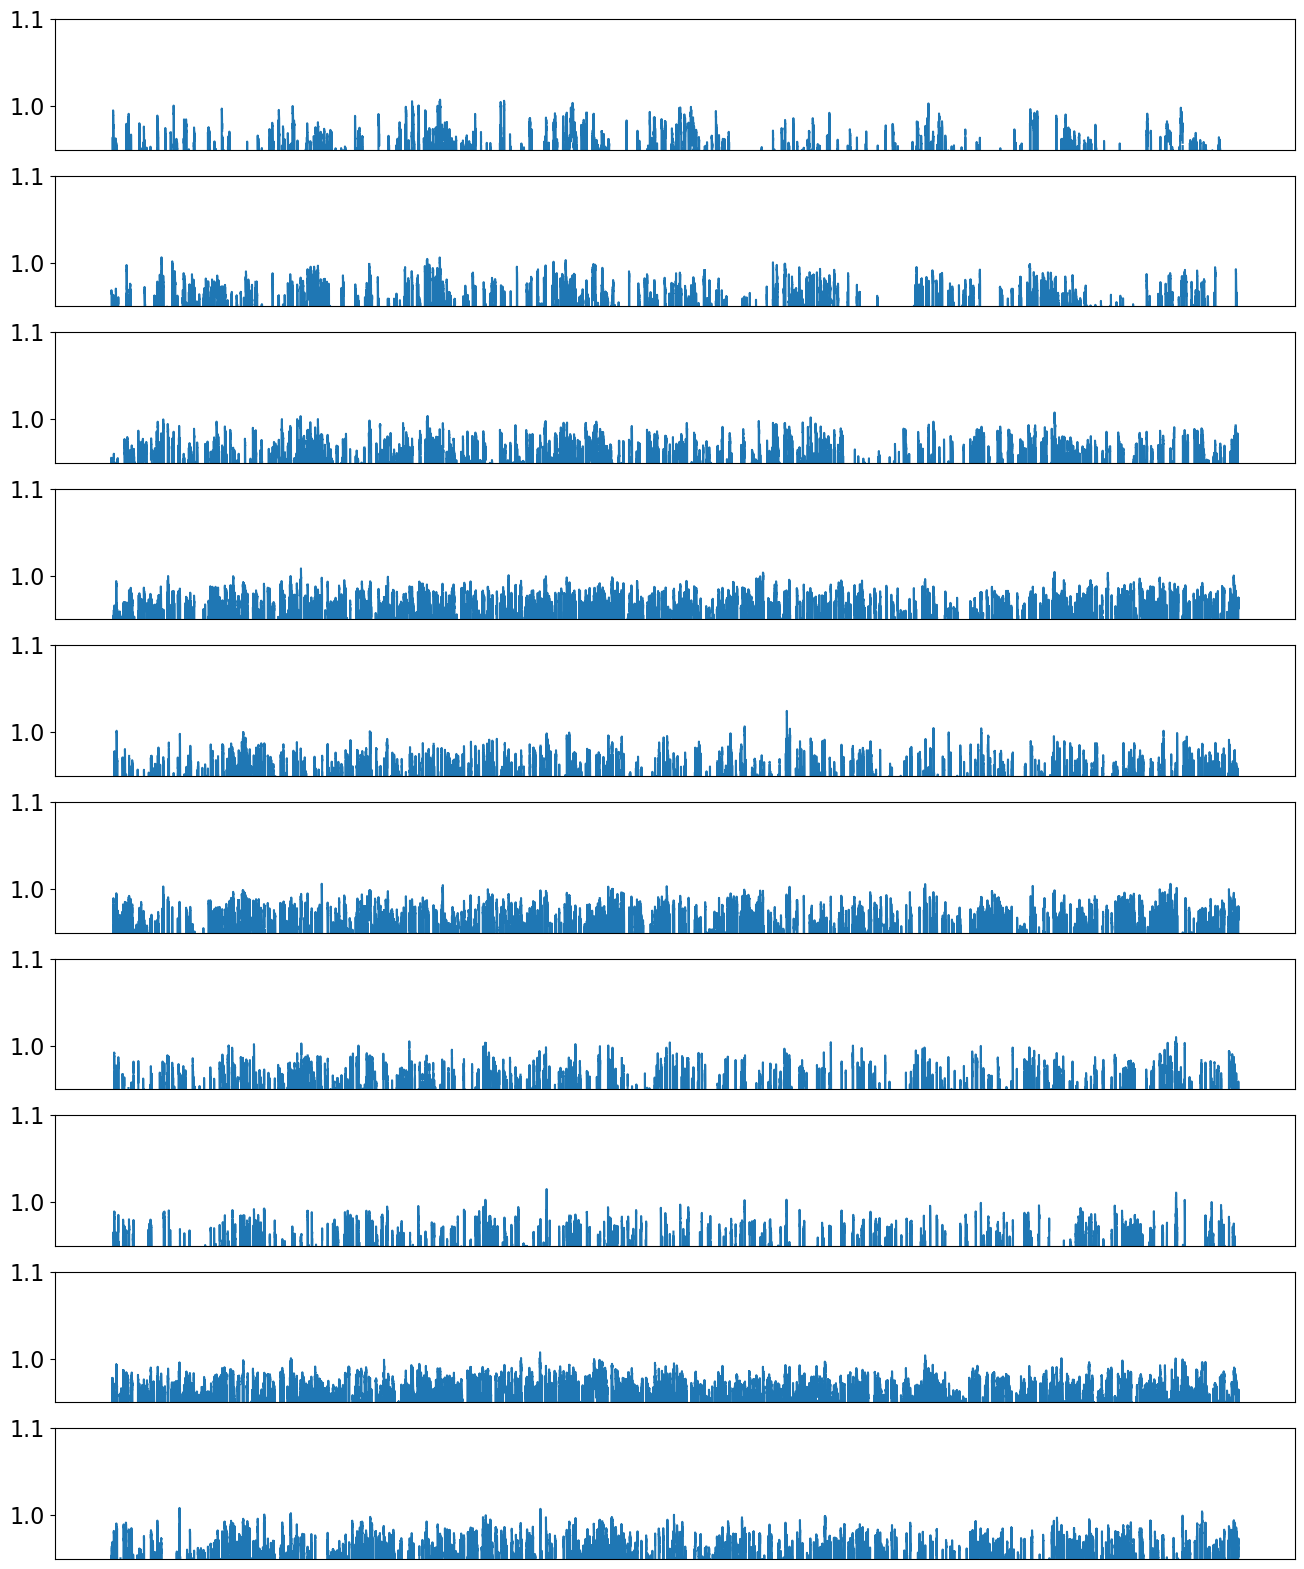

In [14]:
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(16, 20))
for i, reg in enumerate(regions):
    reg_bias = get_bias(ds[reg][mask].groupby('time_of_year').max())
    ds[reg] = ds[reg].groupby('time_of_year') / reg_bias
    ax[i].plot(ds[reg][mask])
    ax[i].set_xticks([])
    ax[i].set_ylim(0.95, 1.1)

### Clip remaining values above 1

In [15]:
ds = ds.clip(max=1)

# Remove missing middle of the day time

In [16]:
ds = ds.where(ds['time'].dt.strftime('%H:%M') != '12:40', drop=True)

# Make a combined "total" variable to represent all regions

In [17]:
stacked = xr.concat([ds[var] for var in ds.data_vars], dim="region")
total = stacked.mean(dim="region")
ds["total"] = total

# Map of Zones

In [18]:
rez_file = '/home/548/cd3022/aus-historical-solar-droughts/data/boundary_files/Indicative REZ boundaries 2024 GIS data.kml'
rez = gpd.read_file(rez_file, engine='pyogrio')

rez['Name'] = rez['Name'].str[:2]

In [20]:
zone_means = {reg: ds[reg].mean(dim='time').item() for reg in regions}

hourly_shortages = {}
daily_droughts = {}
drought_lengths = np.linspace(6,72,23)
for reg in regions:
    hourly = solar_plotting.mean_below_threshold(ds[reg], 0.2, drought_lengths)
    hourly_shortages[reg] = np.sum(hourly[0] * hourly[1])

    daily = solar_plotting.daily_drought(ds[reg], rolling_threshold=0.1, day_threshold=0.4, window=6)
    daily_droughts[reg] = np.sum(daily[0] * daily[1])

rez['mean'] = rez['Name'].map(zone_means)
rez['shortage'] = rez['Name'].map(hourly_shortages)
rez['drought'] = rez['Name'].map(daily_droughts)


rez = rez.dropna(subset=['mean'])

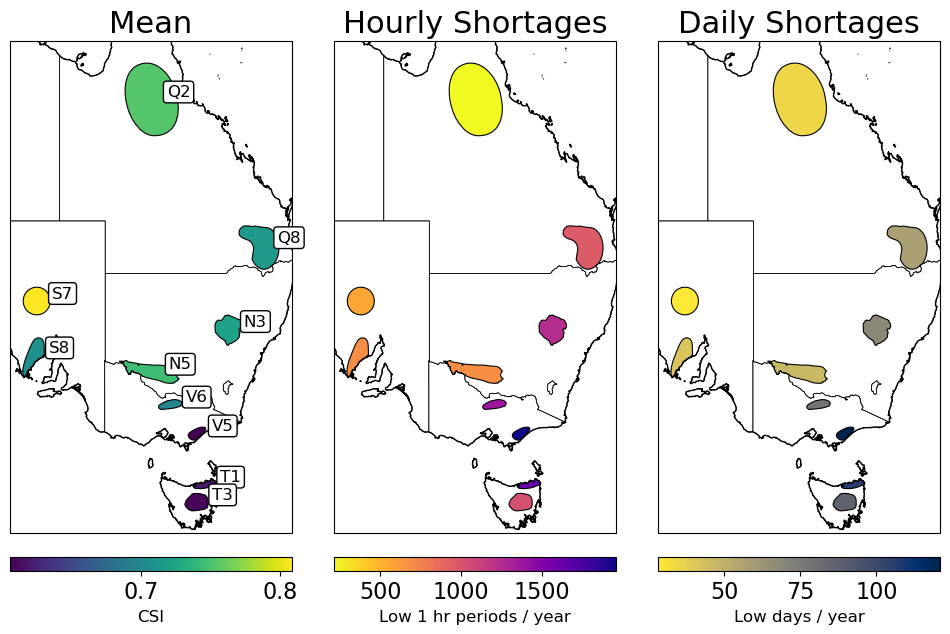

In [21]:
# Define the variables and titles to plot
plot_vars = ['mean', 'shortage', 'drought']
titles = ['Mean', 'Hourly Shortages', 'Daily Shortages']
cbar_lab = ['CSI', 'Low 1 hr periods / year', 'Low days / year']
cmaps = ['viridis', 'plasma_r', 'cividis_r']
vmins = [rez['mean'].min(), rez['shortage'].min(), rez['drought'].min()]
vmaxs = [rez['mean'].max(), rez['shortage'].max(), rez['drought'].max()]

# Create subplots with less horizontal spacing
fig, axes = plt.subplots(
    1, 3,
    figsize=(12, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Reproject once
rez_4326 = rez.to_crs(epsg=4326)

# Loop over variables
for i, var in enumerate(plot_vars):
    ax = axes[i]
    
    # Plot the zones
    rez_4326.plot(
        column=var,
        ax=ax,
        cmap=cmaps[i],
        edgecolor='black',
        linewidth=0.8,
        legend=False,
        vmin=vmins[i],
        vmax=vmaxs[i]
    )
    
    # Add features
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5)
    ax.set_title(titles[i])

    # Add colorbar below each plot, sized to the width of its axis
    sm = mpl.cm.ScalarMappable(cmap=cmaps[i], norm=mpl.colors.Normalize(vmin=vmins[i], vmax=vmaxs[i]))
    sm._A = []
    cbar = fig.colorbar(
        sm, ax=ax,
        orientation='horizontal',
        pad=0.04,
        fraction=0.035,
    )
    cbar.set_label(cbar_lab[i], fontsize=12)

# Reduce space between plots
plt.subplots_adjust(wspace=0.15, bottom=0.15)


from shapely.geometry import MultiPolygon

# Add labels offset to the top-right of each geometry
for idx, row in rez_4326.iterrows():
    geom = row['geometry']
    if geom.is_empty:
        continue
    if isinstance(geom, MultiPolygon):
        geom = max(geom.geoms, key=lambda a: a.area)  # Use the largest polygon

    centroid = geom.centroid
    x, y = centroid.x + 1, centroid.y  # Offset coordinates (adjust as needed)

    axes[0].text(
        x, y,
        row['Name'],
        horizontalalignment='left',
        verticalalignment='bottom',
        fontsize=12,
        transform=ccrs.PlateCarree(),
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
    )

plt.savefig(f'{fig_dir}/CSI-REZ-map.png')
plt.show()

# Constant below threshold

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 7), sharex=True, sharey=True)
ax = ax.flatten()

for i, reg in enumerate(regions):
    cbt = solar_plotting.constant_below_threshold(da=ds[reg], threshold=0.2)
    for season in cbt:
        x = np.array(cbt[season][0])
        y = np.array(cbt[season][1])
        ax[i].plot(x[y > 0], y[y > 0], label=season)
    ax[i].set_title(reg)
    ax[i].grid(True)

    # Set log scale and custom tick formatting for y-axis
    ax[i].set_yscale('log', base=2)
    ax[i].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

# Add legend only to the first subplot
ax[0].legend(title="Season")

# Axis limits and labels
plt.xlim(0, 16)
plt.xticks(range(0, 17, 4))
plt.ylim(0.1,64)
fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7), sharex=True, sharey=True)


cbt = solar_plotting.constant_below_threshold(da=ds_aus.total, threshold=0.5)
for season in cbt:
    x = np.array(cbt[season][0])
    y = np.array(cbt[season][1])
    ax.plot(x[y > 0], y[y > 0], label=season)
ax.set_title("Total")
ax.grid(True)

# Set log scale and custom tick formatting for y-axis
ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2.0))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

# Add legend only to the first subplot
ax.legend(title="Season")

# Axis limits and labels
plt.xlim(0, 16)
plt.xticks(range(0, 17, 4))
plt.ylim(0.1,64)
fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)

plt.tight_layout()

plt.show()

# Mean Below Threshold

In [ ]:
drought_lengths = np.linspace(6, 72, 23)

def format_ticks(val, _):
    if val < 1:
        return f"{val:.1f}"  # Show decimals like 0.5
    else:
        return f"{int(val)}"

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
ax.flatten()

for reg in regions:
    # Hourly MBT
    x_data, mbt_droughts = solar_plotting.mean_below_threshold(ds[reg], 0.2, drought_lengths)
    # x_data = np.divide(sorted(drought_lengths, reverse=True), 6)
    ax[0].plot(x_data, mbt_droughts, label=reg)
    ax[0].grid(True)
    ax[0].set_xlabel('Duration (hrs)', fontsize=16)
    ax[0].set_xlim(1,12)
    ax[0].set_ylim(0.25,120)
    ax[0].set_yscale('log', base=2)
    ax[0].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[0].yaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax[0].set_yticks([0.5, 2, 8, 32])

    # Daily continuous
    x, y = solar_plotting.daily_drought(
        ds[reg],
        rolling_threshold=0.1,
        day_threshold=0.4,
        window=6
    )
    ax[1].plot(x, y, label=reg)
    ax[1].set_xlim(1,8)
    ax[1].set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
    ax[1].set_ylim(0.125,60)
    ax[1].grid(True)
    ax[1].set_xlabel('Duration (days)', fontsize=16)
    ax[1].set_yscale('log', base=2)
    ax[1].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[1].yaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax[1].set_yticks([0.5, 2, 8, 32])

plt.tight_layout(rect=[0.05, 0.05, 0.85, 0.95])
fig.supylabel('Number of events / year', fontsize=16)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.85, 0.5), fontsize=14)

plt.savefig(f'{fig_dir}/CSI-hourly-daily-shortages.png')

# Multi-Day Droughts

In [ ]:
def daily_drought(da, rolling_threshold, day_threshold, window):
    da_rolling = da.rolling(time=window, center=False).mean()
    rolling_droughts = xr.where(da_rolling < rolling_threshold, 1, 0)
    day_droughts_rolling = rolling_droughts.resample(time='1D').max()

    day_means = da.resample(time='1D').mean()
    day_droughts_mean = xr.where(day_means < day_threshold, 1, 0)

    droughts_total = xr.where((day_droughts_rolling + day_droughts_mean) >= 1, 1, 0).values

    drought_lengths = [droughts_total[0]]
    for i_time in range(1, len(droughts_total)):
        drought_past = droughts_total[i_time - 1]
        drought_now = droughts_total[i_time]
        if (drought_now != 0) and (drought_past != 0):
            drought_now += drought_lengths[i_time - 1]
        drought_lengths.append(drought_now)

    duration, freq = np.unique(drought_lengths, return_counts = True)
    duration = duration[1:]
    freq = freq[1:] / len(np.unique(da.time.dt.year))
    return duration, freq


fig, ax = plt.subplots(2, 2, figsize=(16,10))
ax=ax.flatten()

seasons = {
        'DJF': [12,1,2],
        'MAM': [3,4,5],
        'JJA': [6,7,8],
        'SON': [9,10,11]
    }


for i, season in enumerate(seasons):
    season_ds = ds.where(ds.time.dt.month.isin(seasons[season]), drop=True)

    for reg in regions:
        x, y = daily_drought(
            season_ds[reg],
            rolling_threshold=0.2,
            day_threshold=0.4,
            window=6
        )
        ax[i].plot(x, y, label=reg)
    ax[i].set_title(season)
    ax[i].set_xlim(2,8)
    ax[i].set_xticks([2, 3, 4, 5, 6, 7, 8])
    ax[i].set_ylim(0,6)
    ax[i].grid(True)
        
ax[1].legend()

# Day/time Heatmap

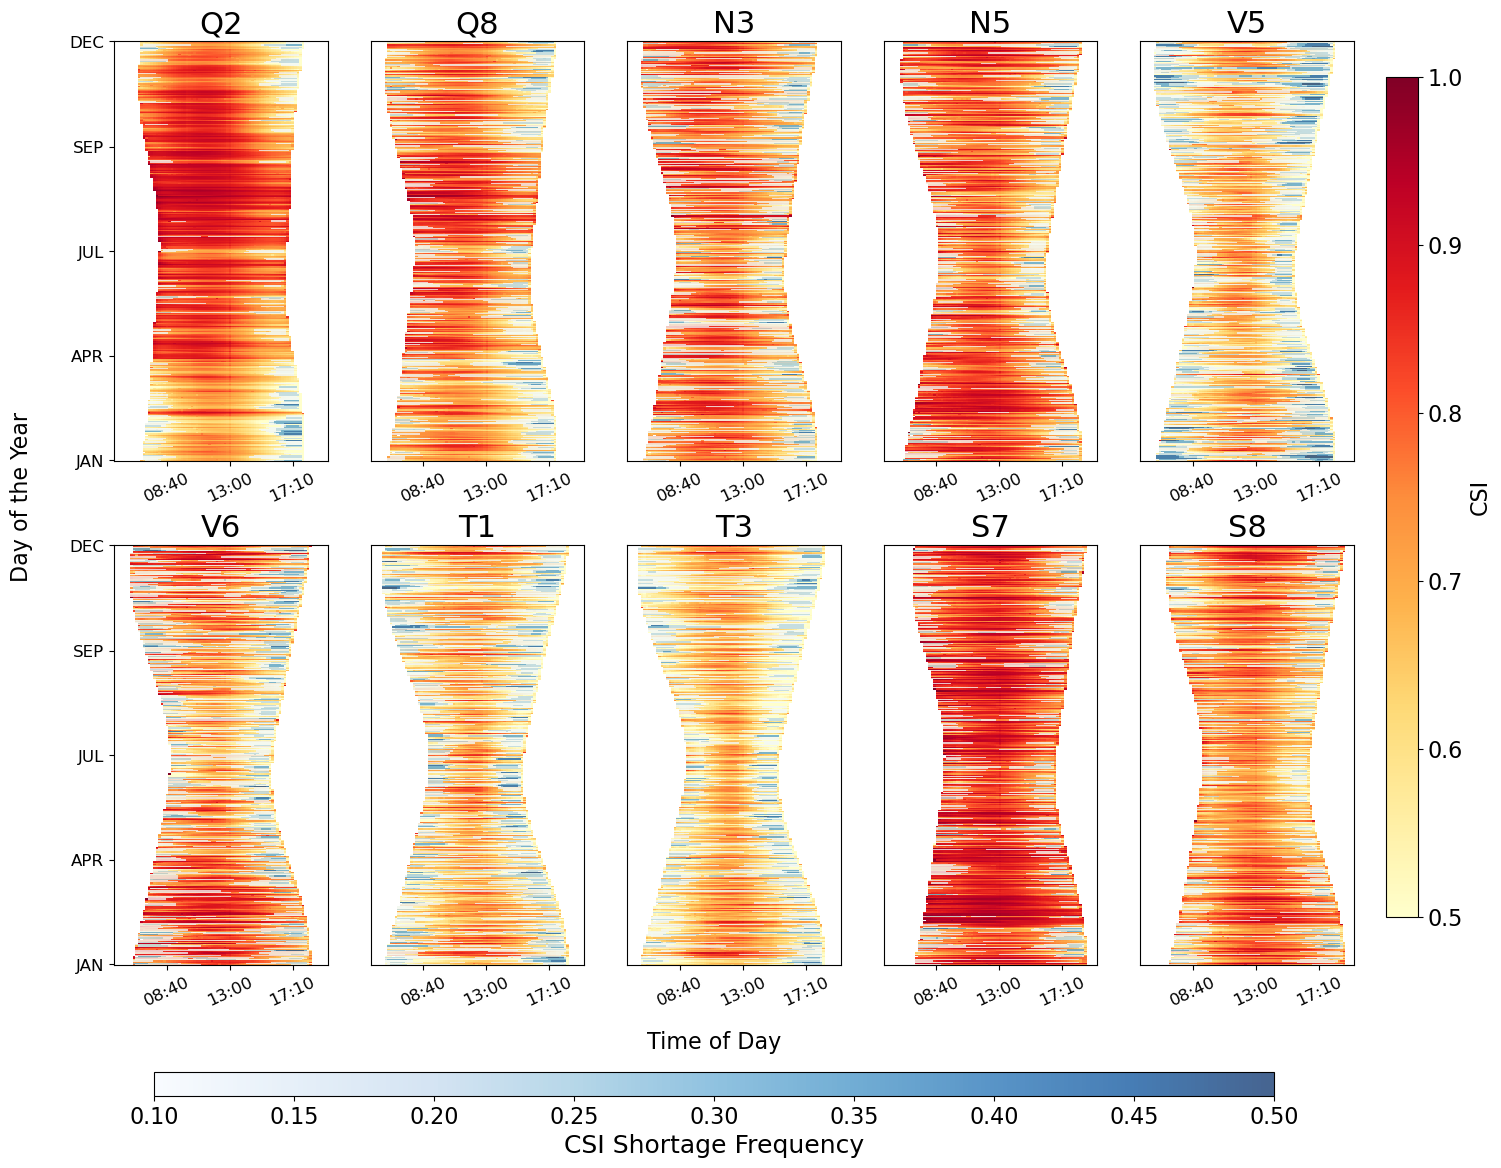

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 12))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar_droughts_ax = fig.add_axes([0.15, 0.001, 0.7, 0.02])

# Create the colormaps
cmap = plt.cm.YlOrRd.copy()
# cmap_droughts = mcolors.LinearSegmentedColormap.from_list(
#     'Blues_top_half', plt.cm.Blues(np.linspace(0.7, 0.71, 256))
# )
cmap_droughts = plt.cm.Blues.copy()

cmap.set_bad(color='white')
cmap_droughts.set_bad(color='none')

im = None
im_droughts = None

for idx, reg in enumerate(regions):
    row, col = divmod(idx, ncols)
    df = solar_plotting.day_time_df(ds[reg])
    df = df.drop(df.columns[49], axis=1)

    # short droughts
    df_droughts = solar_plotting.day_time_mbt(ds[reg], threshold = 0.2, drought_length=1)
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)
    df_droughts[df_droughts == 0] = np.nan
    # df_droughts[~df_droughts.isna()] = 1
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)

    im = ax[row, col].imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0.5, vmax=1, interpolation='none', zorder=0)
    im_droughts = ax[row, col].imshow(df_droughts, aspect="auto", origin="lower", cmap=cmap_droughts, vmin=0.1, vmax=0.5, interpolation='none', zorder=1, alpha=0.75)

    # Axis ticks
    xticks = np.linspace(0, len(df.columns) - 1, 5, dtype=int)
    xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    ax[row, col].set_xticks(xticks)
    ax[row, col].set_xticklabels(xtick_labels, rotation=25, fontsize=12)

    if idx in [0, 5]:
        yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax[row, col].set_yticks(yticks)
        ax[row, col].set_yticklabels(ytick_labels, fontsize=12)
    else:
        ax[row, col].set_yticks([])
    # ax[row, col].set_xticks([])

    ax[row, col].set_xlim(4,89)

    ax[row, col].set_title(reg)

fig.colorbar(im, cax=cbar_ax).set_label('CSI', fontsize=16)
fig.colorbar(im_droughts, cax=cbar_droughts_ax, orientation='horizontal').set_label('CSI Shortage Frequency')
# fig.colorbar(im_droughts_long, cax=cbar_droughts_long_ax, orientation='horizontal', ticks=[]).set_label('')

fig.text(0.5, 0.04, 'Time of Day', ha='center', fontsize=16)  # global x-label
fig.text(0.06, 0.5, 'Day of the Year', va='center', rotation='vertical', fontsize=16)  # global y-label

plt.savefig(f'{fig_dir}/CSI-heatmap.png')
plt.show()

# Coincident Droughts

In [ ]:
coincident_droughts = np.zeros(len(ds_aus.time))
for reg in regions:
    drought_data = xr.where(ds_aus[reg] < 0.2, 1, 0).values
    coincident_droughts += drought_data
coincident_da = xr.DataArray(coincident_droughts, dims=ds_aus.dims, coords=ds_aus.coords)

daily = ds_aus.resample(time="1D").mean()
coincident_droughts_daily = np.zeros(len(daily.time))
for reg in regions:
    drought_data = xr.where(daily[reg] < 0.2, 1, 0).values
    coincident_droughts_daily += drought_data
coincident_da_daily = xr.DataArray(coincident_droughts_daily, dims=daily.dims, coords=daily.coords)

In [ ]:
# Prepare data
df = solar_plotting.day_time_df(coincident_da)
df = df.drop(df.columns[49], axis=1)
df[df == 0] = np.nan

# Create the figure and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(
    2, 3,  # 3 columns: [left (plots), right lineplot, colorbar]
    width_ratios=[4, 1, 0.2],  # Adjust third column for cbar
    height_ratios=[1, 6],
    wspace=0.1,
    hspace=0.05
)

# Create axes
ax_top = fig.add_subplot(gs[0, 0])        # top line plot
ax_heatmap = fig.add_subplot(gs[1, 0])    # main heatmap
ax_right = fig.add_subplot(gs[1, 1])  # right line plot
cbar_ax = fig.add_subplot(gs[1, 2]) 

# Colormap
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# Heatmap
im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=4, interpolation='none')
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Avg Coincident Droughts', fontsize=18)

# Axis ticks - x
xticks = np.linspace(0, len(df.columns) - 1, 4, dtype=int)
xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
ax_heatmap.set_xticks(xticks)
ax_heatmap.set_xticklabels(xtick_labels, rotation=45, fontsize=12)

# Axis ticks - y
yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
ax_heatmap.set_yticks(yticks)
ax_heatmap.set_yticklabels(ytick_labels, fontsize=12)

# Top plot (mean and std across days for each time of day)
mean_daily = df.mean(axis=0)
std_daily = df.std(axis=0)
ax_top.plot(mean_daily.values, color='teal')
ax_top.fill_between(
    np.arange(len(mean_daily)),
    mean_daily - std_daily,
    mean_daily + std_daily,
    color='teal',
    alpha=0.3
)
ax_top.tick_params(axis='x', labelbottom=False)
ax_top.set_yticks([])

# Right plot (mean and std across hours for each day of year)
mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
y = np.arange(df.shape[0])
ax_right.plot(mean_weekly.values, y, color="teal")
ax_right.fill_betweenx(
    y,
    mean_weekly - std_weekly,
    mean_weekly + std_weekly,
    color="teal",
    alpha=0.3
)
ax_right.tick_params(axis='y', labelleft=False)
ax_right.set_xticks([])

plt.show()

In [ ]:
seasons = {
    'summer': [12, 1, 2],
    'autumn': [3, 4, 5],
    'winter': [6, 7, 8],
    'spring': [9, 10, 11]
}

for season in seasons:
    seasonal_data = coincident_da.where(coincident_da.time.dt.month.isin(seasons[season]), drop=True)
    morning_data = seasonal_data.where(seasonal_data.time.dt.hour < 12, drop=True)
    afternoon_data = seasonal_data.where(seasonal_data.time.dt.hour >= 12, drop=True)

    fig, axes = plt.subplots(
        nrows=1, ncols=10, figsize=(20, 8),
        constrained_layout=True
    )

    all_regions = list(regions)  # ensure legend includes all
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_regions)))[:, :3]

    i = 0
    for num_droughts in range(4, 9):
        for tod_label, time_of_day in zip(["Morning", "Afternoon"], [morning_data, afternoon_data]):
            times = time_of_day[time_of_day == num_droughts].time.data

            if len(times) == 0:
                axes[i].set_xticks([])
                axes[i].set_yticks([])
                axes[i].set_title(f"{tod_label}\n{num_droughts} droughts\n(No data)")
                for spine in axes[i].spines.values():
                    spine.set_visible(False)
                i += 1
                continue

            # Build DataFrame
            data = {
                reg: coincident_drought_ds[reg].sel(time=times).data.astype(int)
                for reg in all_regions
            }
            df = pd.DataFrame(data, index=times)

            rgb_img = np.ones((len(df), len(df.columns), 3))
            for j, col in enumerate(df.columns):
                rgb_img[df[col].values == 1, j, :] = colors[j]

            axes[i].imshow(rgb_img, aspect='auto', interpolation='none')
            axes[i].set_title(f"{tod_label}\n{num_droughts} droughts")
            axes[i].set_xticks([])
            axes[i].set_xticklabels([])
            axes[i].set_yticks([])
            axes[0].set_yticks(np.linspace(0, 330, 6, dtype=int))
            axes[0].set_ylabel("Frequency")
            axes[i].set_ylim(0, 330)
            for spine in axes[i].spines.values():
                spine.set_visible(False)

            i += 1

    # Legend
    legend_elements = [Patch(facecolor=colors[j], label=reg) for j, reg in enumerate(all_regions)]
    fig.legend(handles=legend_elements, loc='center right', title='Regions')

    fig.suptitle(f"{season.capitalize()}", fontsize=18)
    plt.show()

In [ ]:
def regional_correlations(ds):
    # Stack each variable into a new 'variable' dimension
    data = xr.concat(
        [ds[var].expand_dims(variable=[var]) for var in ds.data_vars],
        dim='variable'
    )
    data = data.dropna(dim='time', how='any')
    data = data.transpose('variable', 'time')  # shape: (variable, time)
    
    # Compute pairwise correlations
    var_names = data['variable'].values
    n = len(var_names)

    corr = np.empty((n, n), dtype=np.float64)

    for i in range(n):
        for j in range(n):
            corr[i, j] = xr.corr(data.sel(variable=var_names[i]),
                                 data.sel(variable=var_names[j]),
                                 dim='time').item()

    return pd.DataFrame(corr, index=var_names, columns=var_names)

In [ ]:
corr_df = regional_correlations(ds).iloc[:-1,:-1]

In [ ]:
plt.figure(figsize=(16,10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Regional Correlations')
plt.show()

In [ ]:
coincident_dict = {}
for reg in regions:
    coincident_dict[reg] = []
    for second_reg in regions:
        total = sum(xr.where(ds[reg] < 0.2, 1, 0).data)
        coincident = sum(xr.where((ds[reg] < 0.2) & (ds[second_reg] < 0.2), 1, 0).data)
        coincident_dict[reg].append(coincident/total)
coincident_df = pd.DataFrame(coincident_dict, index=coincident_dict.keys())

In [ ]:
plt.figure(figsize=(16,10))
sns.heatmap(coincident_df, annot=True, cmap='Reds', vmin=0, vmax=1)
plt.title('Regional Coincidence of Droughts')
plt.xlabel('Region in Drought')
plt.ylabel('Second Region')
plt.show()

In [ ]:
seasons = {
    'summer': [12,1,2],
    'autumn': [3,4,5],
    'winter': [6,7,8],
    'spring': [9,10,11]
}

fig, ax = plt.subplots(figsize=(20, 10))

bar_width = 0.2
season_names = list(seasons.keys())
season_offsets = np.arange(-1.5, 2) * bar_width  # for 4 seasons

for i, season in enumerate(season_names):
    data = coincident_da.where(coincident_da.time.dt.month.isin(seasons[season]), drop=True).values
    num, freq = np.unique(data.data, return_counts=True)

    # Remove zero entry
    num = num[1:]
    freq = freq[1:] / len(np.unique(coincident_da.time.dt.year))

    # Shift bar positions
    x_pos = num + season_offsets[i]
    ax.bar(x_pos, freq, width=bar_width, label=season)

ax.set_xlim(3.5, 8.5)
ax.set_ylim(0, 60)
ax.set_xlabel("Number of coincident events")
ax.set_ylabel("Average frequency per year")
ax.legend()

In [ ]:
# Prepare data
# Prepare data
coincident_daily = coincident_da.resample(time="1D").max()
df = solar_plotting.day_year_df(coincident_daily)
# df[df == 0] = np.nan

# Create the figure and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(
    2, 3,  # 3 columns: [left (plots), right lineplot, colorbar]
    width_ratios=[4, 1, 0.2],  # Adjust third column for cbar
    height_ratios=[1, 6],
    wspace=0.1,
    hspace=0.05
)

# Create axes
ax_top = fig.add_subplot(gs[0, 0])        # top line plot
ax_heatmap = fig.add_subplot(gs[1, 0])    # main heatmap
ax_right = fig.add_subplot(gs[1, 1])  # right line plot
cbar_ax = fig.add_subplot(gs[1, 2]) 

# Colormap
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# Heatmap
im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=8, interpolation='none')
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Avg Coincident Droughts', fontsize=18)

# X-axis: years
xticks = np.arange(len(df.columns))
xtick_labels = df.columns.astype(str)
ax_heatmap.set_xticks(xticks)
ax_heatmap.set_xticklabels(xtick_labels, rotation=45)

# Axis ticks - y
yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
ax_heatmap.set_yticks(yticks)
ax_heatmap.set_yticklabels(ytick_labels, fontsize=12)

# Top plot (mean and std across days for each time of day)
mean_daily = df.mean(axis=0)
std_daily = df.std(axis=0)
ax_top.plot(mean_daily.values, color='teal')
ax_top.fill_between(
    np.arange(len(mean_daily)),
    mean_daily - std_daily,
    mean_daily + std_daily,
    color='teal',
    alpha=0.3
)
ax_top.tick_params(axis='x', labelbottom=False)
ax_top.set_yticks([])

# Right plot (mean and std across hours for each day of year)
mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
y = np.arange(df.shape[0])
ax_right.plot(mean_weekly.values, y, color="teal")
ax_right.fill_betweenx(
    y,
    mean_weekly - std_weekly,
    mean_weekly + std_weekly,
    color="teal",
    alpha=0.3
)
ax_right.tick_params(axis='y', labelleft=False)
ax_right.set_xticks([])

plt.show()

In [ ]:
coincident_drought_matrix

In [ ]:
# Example boolean matrix: True where values are below the threshold
threshold = 0.2
coincident_drought_ds = ds_aus < threshold

# Convert to 2D for plotting: variable x time
coincident_drought_matrix = xr.concat([coincident_drought_ds[var] for var in ds_aus.data_vars], dim="variable")
coincident_drought_matrix["variable"] = list(ds_aus.data_vars)

In [ ]:
df = coincident_drought_matrix.transpose("time", "variable").to_pandas().astype(int)
df = df.drop(columns='total')

In [ ]:
df_cut = df.iloc[200:400,:]

# Stacked area plot directly (no cumulative sum needed)
df_cut.plot.area(figsize=(12, 6), cmap="tab10")
plt.title("Which series are below threshold over time")
plt.xlabel("Time")
plt.ylabel("Below-threshold indicator (stacked)")
plt.legend(title="Series", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
plt.xlim(0,1000)

# Worst Events

In [ ]:
threshold = 0.35
data = ds_aus.total.dropna(dim='time').rolling(time=100).mean()
events = xr.where(data < threshold, data, np.nan).dropna(dim='time')
np.unique(events.time.to_index().date)

In [ ]:
ds_aus.total.dropna(dim='time').rolling(time=100).mean().plot()
plt.axhline(threshold, color='r', linestyle = '--')

# Spectral Analysis

In [ ]:
def spectral_fft(da, time_res=False, clim=False, window=False):
    if time_res:
        da = da.resample(time=time_res).mean()
    if window:
        da = da.rolling(time=window, center=True, min_periods=1).mean()
    if clim:
        climatology = da.groupby("time.dayofyear").mean("time")
        da = da.groupby("time.dayofyear") - climatology
    clean = da.dropna(dim="time")
    data = (clean - clean.mean(dim='time')).values

    N = len(data)
    fft_vals = np.fft.fft(data)
    freqs = np.fft.fftfreq(N, d=1)
    
    positive = freqs > 0
    freqs_pos = freqs[positive]
    power = np.abs(fft_vals[positive])**2 / N**2

    # Normalize to match variance via Parseval
    delta_f = freqs_pos[1] - freqs_pos[0]
    power *= np.var(data) / (np.sum(power) * delta_f)

    periods = 1 / freqs_pos
    return periods, power

In [ ]:
time_res = False
clim = True
window=700

fig, ax = plt.subplots(nrows = len(regions), ncols = 1, figsize=(16,16), sharex=True)

for i, reg in enumerate(regions):

    fft_periods, fft_power = spectral_fft(da=ds_aus[reg], time_res=time_res, clim=clim, window=window)
    # welch_periods, welch_power = solar_plotting.spectral_welch(da=ds_aus[reg], nperseg=2048, time_res=time_res, clim=clim)
    # mt_periods, mt_power = solar_plotting.spectral_multitaper(da=ds_aus[reg], NW=2.5, k=4, time_res=time_res, clim=clim)
    # mt_mask = mt_periods >= np.min(fft_periods)
    
    ax[i].semilogx(fft_periods, fft_power, label='fft')
    # ax[i].semilogx(welch_periods, welch_power, label='welch', linestyle = '--')
    # ax[i].semilogx(mt_periods[mt_mask], mt_power[mt_mask], label='Multitaper', linestyle = ':')
    ax[i].set_ylabel(reg, rotation=0, labelpad=30)
    # ax[i].set_xlim(1,100)
    # ax[i].set_ylim(0,20)
    
    fig.gca().invert_xaxis()
ax[0].legend()
plt.xlim(window)
plt.tight_layout()

In [ ]:
# Wavelet

for reg in regions:
    # daily = ds_aus[var].resample(time="1D").mean()
    clean = ds_aus[reg].dropna(dim="time")
    data = clean - clean.mean(dim="time")
    signal = data.values
    
    scales = np.arange(1, 100)
    coefficients, freqs = pywt.cwt(signal, scales=scales, wavelet='morl', sampling_period=1)
    
    # Compute power and apply log scale (add small constant to avoid log(0))
    power = np.abs(coefficients) ** 2
    log_power = np.log2(power + 1e-8)
    
    plt.figure(figsize=(14, 6))
    im = plt.imshow(power,
                    extent=[0, len(signal), scales[-1], scales[0]], #vmax = 3,
                    aspect='auto', cmap='RdYlBu_r')
    
    plt.gca().invert_yaxis()
    cbar = plt.colorbar(im)
    cbar.set_label("Power")
    
    plt.xlabel("Time (samples since start)")
    plt.ylabel("Period (number of samples)")
    plt.title(reg)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()